
# Genereative Adversarial Networks

The main goal of **Generative Adversarial Network** (GAN) is to generate images that are similar (but not identical) to training dataset.

GAN consists of two neural networks that are trained against each other:

 * **Generator** takes a random vector, and should generate an image from it
 * **Discriminator** is a networks that should distinguish between original image (from training dataset), and the one generated by the generator.

<img src="./images/gan_architecture.png" width="70%"/>

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import numpy as np

## Generator

The role of a generator is to take a random vector of some size (it is similar to latent vector in autoencoders) and generate the target image. It is very similar to the generative side of autoencoder.

In our example, we will use dense neural networks and MNIST dataset.

In [14]:
generator = Sequential()
generator.add(Dense(256, input_shape=(100,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784, activation='tanh'))
generator.add(Reshape((28,28)))

optimizer = keras.optimizers.Adam(lr=0.0002, decay=8e-9)

generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


A few tricks used in generator:
* Instead of ReLU, we use **Leaky ReLU**, i.e. a ReLU which is not exactly 0 for negative $x$, but rather another linear function with very small slope. This is important, because it helps gradient descent to propagate values even if we are on the negative side of ReLU (where values are 0)
* We use Batch Normalization in order to stabilize training
* The activation function on last layer is `tanh`, so the output is in the range [-1,1]

## Discriminator

Discriminator is a classical image classification network. In our first example, we will also use dense classifier.

In [15]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=(28,28)))
discriminator.add(Dense(784))

discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(784//2))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

We will also define an adversarial network, which is generator followed by discriminator. This network starts with a noise vector, and returns a binary result.

In [4]:
discriminator.trainable = False
adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)
adversarial.compile(loss='binary_crossentropy', optimizer=optimizer)

## Loading dataset

We will use MNIST dataset, built into Keras:

In [17]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

## Network training

On each step of the training, we have two phases:

* Training discriminator:
   - We generate some random vectors `noise`. Training happens in minibatches, so we use `batch//2` vectors to produce `batch//2` generated images
   - Sample `batch//2` random images from the dataset
   - Train discriminator on 50% real and 50% generated images, providing corresponding labels (0 or 1)
 * Train the generator by using combined adversarial model, passing random vectors as input, and expecting 1's as output (which corresponds to real images)

In [18]:
def plotn(n):
  noise = np.random.normal(0, 1, (n,100))
  imgs = generator.predict(noise)
  fig,ax = plt.subplots(1,n)
  for i,im in enumerate(imgs):
    ax[i].imshow(im.reshape(28,28))
  plt.show()

epoch: 0, [Discriminator :: d_loss: 0.601463], [ Generator :: loss: 0.640677]


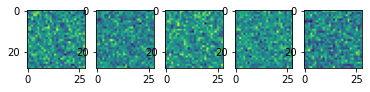

epoch: 500, [Discriminator :: d_loss: 0.192001], [ Generator :: loss: 12.124918]


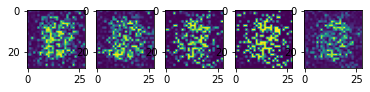

epoch: 1000, [Discriminator :: d_loss: 0.141956], [ Generator :: loss: 1.900380]


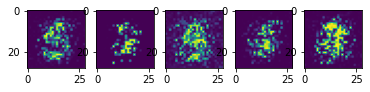

epoch: 1500, [Discriminator :: d_loss: 0.293635], [ Generator :: loss: 2.443017]


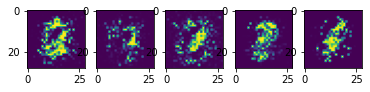

epoch: 2000, [Discriminator :: d_loss: 0.547135], [ Generator :: loss: 2.680543]


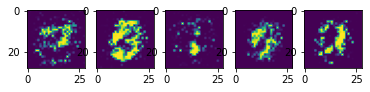

epoch: 2500, [Discriminator :: d_loss: 0.491767], [ Generator :: loss: 2.633016]


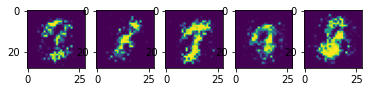

In [7]:
batch=32
for cnt in range(3000):
## train discriminator
  random_index =  np.random.randint(0, len(X_train) - batch//2)
  legit_images = X_train[random_index : random_index + batch//2].reshape(batch//2, 28, 28)
  gen_noise = np.random.normal(0, 1, (batch//2,100))
  syntetic_images = generator.predict(gen_noise)
  x_combined_batch = np.concatenate((legit_images, syntetic_images))
  y_combined_batch = np.concatenate((np.ones((batch//2, 1)), np.zeros((batch//2, 1))))
  d_loss = discriminator.train_on_batch(x_combined_batch, y_combined_batch)
# train generator
  noise = np.random.normal(0, 1, (batch,100))
  y_mislabled = np.ones((batch, 1))
  g_loss = adversarial.train_on_batch(noise, y_mislabled)
  if cnt%500==0:
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))
    plotn(5)

> **Task**: You can train this GAN on the whole MNIST dataset and see how good can it get

## DCGAN

In the previous example, we have used dense networks for both generator and discriminator, but we know that CNNs provide better performance when dealing with images. **Deep Convolutional GAN** is similar to the architecture above, but it uses convolutional layers for generator and discriminator. 

The main difficulty here is to build an architecture for denerator, because it has to do an inverse task compared to traditional CNN - it has to generate image from feature vector. In a way, this is similar to decoder part of autoencoders.That's why we will be using `Conv2DTranspose` layers in the generator.

In [19]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32)-127.5) / 127.5
print(X_train.min(),X_train.max())

-1.0 1.0


In [9]:
generator = Sequential()
generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2DTranspose(1, kernel_size=3, padding="same"))
generator.add(Activation("tanh"))

optimizer = keras.optimizers.Adam(0.0001) #, 0.5)

generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)      

In [10]:
discriminator = Sequential()

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)

In [11]:
discriminator.trainable = False
adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)
adversarial.compile(loss='binary_crossentropy', optimizer=optimizer)

epoch: 0, [Discriminator :: d_loss: 0.957905], [ Generator :: loss: 0.695994]


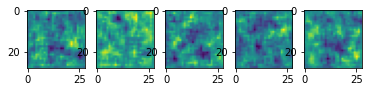

epoch: 100, [Discriminator :: d_loss: 0.826593], [ Generator :: loss: 1.488088]


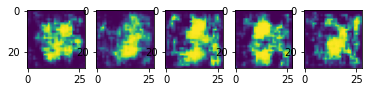

epoch: 200, [Discriminator :: d_loss: 0.602254], [ Generator :: loss: 1.362499]


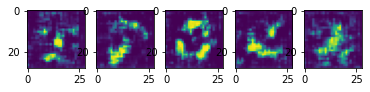

epoch: 300, [Discriminator :: d_loss: 0.711605], [ Generator :: loss: 1.224355]


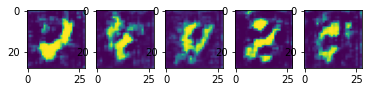

epoch: 400, [Discriminator :: d_loss: 0.650690], [ Generator :: loss: 0.899742]


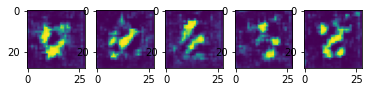

epoch: 500, [Discriminator :: d_loss: 0.413256], [ Generator :: loss: 1.106550]


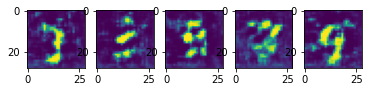

epoch: 600, [Discriminator :: d_loss: 0.574668], [ Generator :: loss: 1.045400]


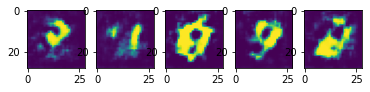

epoch: 700, [Discriminator :: d_loss: 0.522089], [ Generator :: loss: 1.068755]


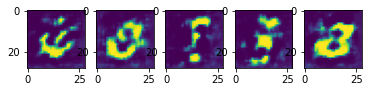

epoch: 800, [Discriminator :: d_loss: 0.300957], [ Generator :: loss: 1.292961]


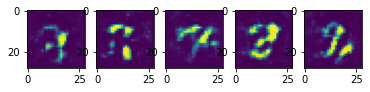

epoch: 900, [Discriminator :: d_loss: 0.389556], [ Generator :: loss: 0.942707]


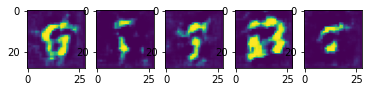

In [12]:
batch=32
y_labeled = np.ones((batch, 1))
y_mislabeled = np.zeros((batch, 1))
for cnt in range(1000):
## train discriminator
  random_index =  np.random.randint(0, len(X_train) - batch)
  legit_images = X_train[random_index : random_index + batch].reshape(batch, 28, 28, 1)
  gen_noise = np.random.normal(0, 1, (batch,100))
  syntetic_images = generator.predict(gen_noise)
  d_loss_1 = discriminator.train_on_batch(legit_images, y_labeled)
  d_loss_2 = discriminator.train_on_batch(syntetic_images, y_mislabeled)
  d_loss = 0.5*np.add(d_loss_1,d_loss_2)
# train generator
  g_loss = adversarial.train_on_batch(gen_noise, y_labeled)
  if cnt%100==0:
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss, g_loss))
    plotn(5)

> **Task**: Try generating more complex color images with DCGAN - for example, take one class from [CIFAR-10](https://keras.io/api/datasets/cifar10/) dataset.

## Training on Paintings

One of the good candidates for GAN training are paintings created by human artists. Below is a sample image produced by DCGAN trained on a dataset from [WikiArt](http://wikiart.org). [KeraGAN](http://github.com/shwars/keragan) library was used to produce this image [using Azure Machine Learning](https://soshnikov.com/scienceart/creating-generative-art-using-gan-on-azureml/)

![](https://soshnikov.com/images/artartificial/Flo1.jpg)

(Photo from [Art of Artificial](https://soshnikov.com/museum/art-artificial/) collection)

## References

* [Keras implementation of different toy GAN architectures](https://github.com/eriklindernoren/Keras-GAN)
* [KeraGAN Library](http://github.com/shwars/Keragan)
* [Blog post about creating GANs on Azure ML](https://soshnikov.com/scienceart/creating-generative-art-using-gan-on-azureml-ru/)